In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 13})
plt.rcParams["figure.figsize"] = (5,5)
import re
from numpy import genfromtxt

import glob as glob
import pandas as pd
import pickle 
folder = "train_with_age_sex/evals_variation0/"
folder = "k0_evals_variation0/"
# folder = "../c22_v5_cyclicalweight_IIL/evalsk0/checkpoints_3d_saved_path"
files = glob.glob(folder + "*.csv")
# files = [i for i in files if "final" not in i]

print(files)
print(len(files))

import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 14})
plt.rcParams["figure.figsize"] = (9,9)
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

import tensorflow as tf



[]
0


2023-04-04 09:19:26.569542: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 09:19:26.703783: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 09:19:26.737372: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-04 09:19:27.373487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [46]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print(cuda_version)
  
cudnn_version = sys_details["cudnn_version"]  
print(cudnn_version)
from tensorflow.keras import mixed_precision


policy = mixed_precision.Policy('mixed_float16')
policy = tf.keras.mixed_precision.set_global_policy('mixed_float16')

11.2
8


In [ ]:
for site_idx in range(0, 21):
    val_data = np.load("train_val_split_variation_8020_0"+"/CovidData2022_cohort"+str(site_idx)+"test.npy", allow_pickle=True)
#   train_data = np.load("iid_data_variation_8020_0/iid_train_split"+str(site_idx)+"train.npy", allow_pickle=True)

    client_val_idx = "c"+str(site_idx)+"_x"
    client_val_idy = "c"+str(site_idx)+"_y"
    val_x =  val_data[client_val_idx].copy()
    val_y =  val_data[client_val_idy].copy()
    if site_idx == 0:
        val_x_all = val_x.copy()
        val_y_all = np.zeros((len(val_y)),dtype=np.uint32)
    else:
        val_x_all = np.concatenate((val_x_all, val_x), axis=0)
        val_y_all = np.concatenate((val_y_all, np.ones((len(val_y)),dtype=np.uint32)*site_idx ), axis=0)
val_x = val_x_all.copy()
val_y = val_y_all.copy()
test_dataset = tf.data.Dataset.from_tensor_slices((val_x, val_y))




In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = confusion_matrix(labels_tot, preds_tot, normalize='true')
df_cm = pd.DataFrame(array, index = [i for i in range(21)],
                    columns = [i for i in range(21)])
plt.figure(figsize = (13,10))
sn.heatmap(df_cm, annot=False, fmt='g')
plt.title("Confusion matrix for model "+str(model_id)+" on test set")
plt.show()


In [121]:
print(len(test_dataset))
print(test_dataset)
num_steps = len(val_x)
BATCH_SIZE = 64

test_dataset_ = test_dataset.map(test_map).batch(BATCH_SIZE)


2817
<TensorSliceDataset element_spec=(TensorSpec(shape=(256, 256, 24, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint32, name=None))>


In [136]:
import aux_models as aux_models
model = aux_models.i3d_v2()
model_id = 9

fl_ckpt_path_1 = "checkpoints_attackers/attacker_id" + str(model_id)+".h5"
model.load_weights(fl_ckpt_path_1)



layerb1:  (None, 24, 256, 256, 3)
shape of global avg pool: (None, 2, 1, 1, 1024)


In [137]:
num_steps = len(val_x)

import tensorflow_addons as tfa
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_auc = tf.keras.metrics.AUC(num_thresholds=10000)
test_auc2 = tf.keras.metrics.AUC(num_thresholds=10000)
test_auc3 = tf.keras.metrics.AUC(num_thresholds=10000)
# f1_metric = tfa.metrics.F1Score(num_classes=21, average="weighted") # threshold is argmax
f1_metric = tfa.metrics.F1Score(num_classes=21) #
f1_metric_weighted = tfa.metrics.F1Score(num_classes=21, average="weighted") #
epochs = []
f1_scores = []
f1_scores_weighted = []
# clients_scaling_factor = np.array([4167.0, 304, 60, 234, 74, 250, 61, 90, 319, 764, 174, 1110, 272,51,237, 433,91,169,807,203,1366])

num_eval_steps = num_steps // BATCH_SIZE
losses = 0.0
classification_loss = 0.0
preds_tot = []
labels_tot = []

for (batch, (x,  z)) in enumerate(test_dataset_.take(num_eval_steps)):
    print("batch", batch, "x.shape:", x.shape, "z.shape", z.shape)
    logits = model(x, training=False)
    # print(logits)
    # print(logits.shape)
    preds = np.argmax(logits.numpy(), axis=1)
    print(preds.shape)
    print(preds)
    labels = z.numpy()
    preds_tot.extend(preds)
    labels_tot.extend(labels)

    # test_accuracy.update_state(z, logits)

    # depth = 21
    # zz  =z.numpy()
    # logits_np = logits.numpy()
    # # print(zz, logits_np)
    # z2 = tf.one_hot(zz, depth)
    # f1_score.update_state(z2, logits_np)
    # f1_score_weighted.update_state(z2, logits_np)

# return f1_score.result().numpy(), f1_score_weighted.result().numpy()



batch 0 x.shape: (64, 24, 256, 256, 1) z.shape (64,)
(64,)
[ 2  0  0  3  0  0 18  0  0  0  0  0  0  0  0  0  0 19  0  0 13  0 19  0
  7  0  0  0  0  3  0  0  7  0  0  0  0  1  0  0  0  0  0  0  0  0  0 10
  0 10 17  0  0  0  0 18  3  0  0  0  0  0  0 19]
batch 1 x.shape: (64, 24, 256, 256, 1) z.shape (64,)
(64,)
[19  0  0  0  0  3 19  0  0  0  0  0 10  7 15  0  0  0  3  0  3  0  0  3
  0  0 14 14  0  0  0  0  0  0  0  0  0 13 19  0  0  0  0  0  0  0  0 10
 17  0  0  0  0  0 19  0  0  3  0  0  0  0 17  2]
batch 2 x.shape: (64, 24, 256, 256, 1) z.shape (64,)
(64,)
[17  9  0  0  0  0  0 19 19 19  0  0  0  0 13  0  0  0  0  0 14  0  0 19
  0  0  3  7  0  0  0  0  0  0  0  0  0  0  0  0 19  0  0 16  0  0 13  0
  0  0  0  0  0  0  0  2  0 13  0  1  0  8 19  0]
batch 3 x.shape: (64, 24, 256, 256, 1) z.shape (64,)
(64,)
[ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0
  0  0 10 19  0  0  0  1  0  0 14  0  0  0  0  7 14  0  0  0  0  0  0  0
  0  0 10  0  3  3 10  0  0  0

In [138]:
from sklearn.metrics import f1_score
# >>> y_true = [0, 1, 2, 0, 1, 2]
# >>> y_pred = [0, 2, 1, 0, 0, 1]

preds_tot = np.array(preds_tot)
print(preds_tot.shape)
labels_tot = np.array(labels_tot)
print(labels_tot.shape)

f1_ = f1_score(labels_tot, preds_tot, average='weighted')
print(f1_)

# print(labels_tot)
# print(preds_tot)


(2816,)
(2816,)
0.5095230703988366


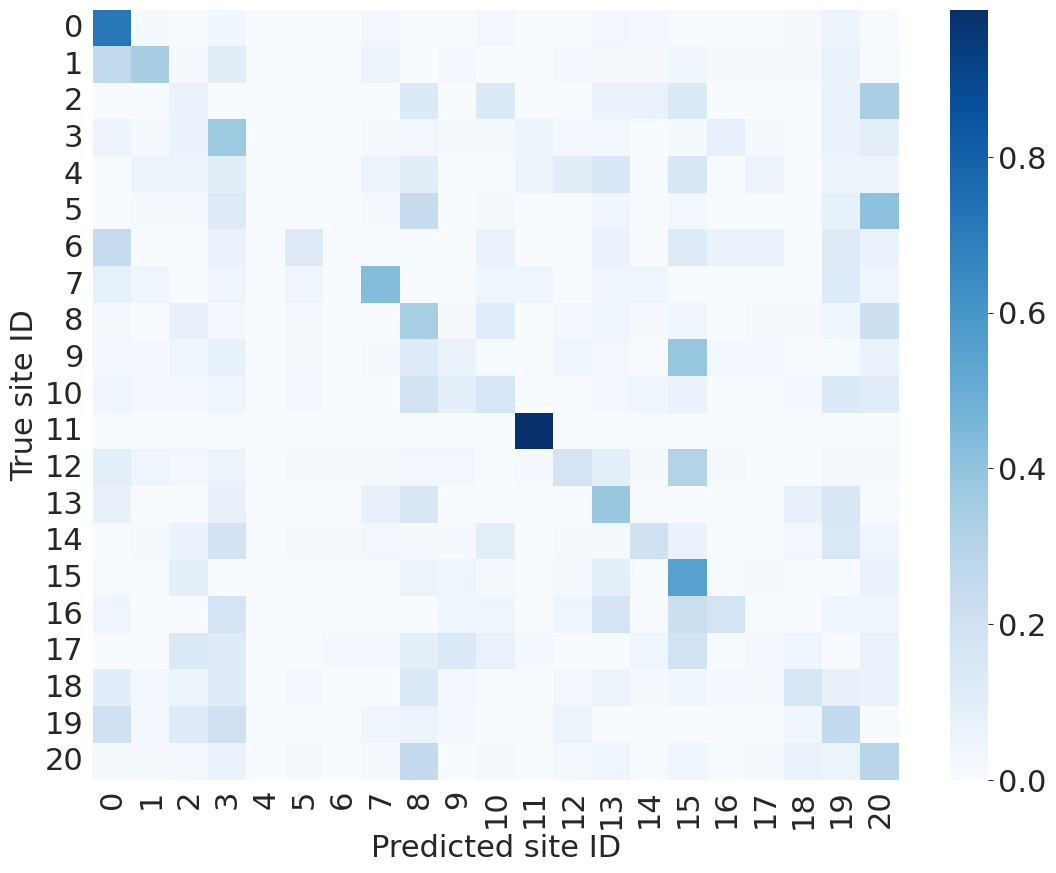

0.5095230703988366


In [139]:
###############################
#model id = 9 (cds)



from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

array = confusion_matrix(labels_tot, preds_tot, normalize='true')
df_cm = pd.DataFrame(array, index = [i for i in range(21)],
                    columns = [i for i in range(21)])
plt.figure(figsize = (13,10))
sn.heatmap(df_cm, annot=False, fmt='g', cmap=plt.cm.Blues)
# plt.imshow(array, interpolation='nearest', cmap=plt.cm.Blues)

# plt.title("Confusion matrix for model "+str(model_id)+" on test set")
plt.xlabel("Predicted site ID")
plt.ylabel("True site ID")
plt.show()
print(f1_)


In [140]:
# ###############################
# #model id = 8 (cds)



# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 22})

# array = confusion_matrix(labels_tot, preds_tot, normalize='true')
# df_cm = pd.DataFrame(array, index = [i for i in range(21)],
#                     columns = [i for i in range(21)])
# plt.figure(figsize = (13,10))
# sn.heatmap(df_cm, annot=False, fmt='g', cmap=plt.cm.Blues)
# # plt.imshow(array, interpolation='nearest', cmap=plt.cm.Blues)

# # plt.title("Confusion matrix for model "+str(model_id)+" on test set")
# plt.xlabel("Predicted site ID")
# plt.ylabel("True site ID")
# plt.show()
# print(f1_)


In [141]:
# ###############################
# #model id = 1



# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 22})

# array = confusion_matrix(labels_tot, preds_tot, normalize='true')
# df_cm = pd.DataFrame(array, index = [i for i in range(21)],
#                     columns = [i for i in range(21)])
# plt.figure(figsize = (13,10))
# sn.heatmap(df_cm, annot=False, fmt='g', cmap=plt.cm.Blues)
# # plt.imshow(array, interpolation='nearest', cmap=plt.cm.Blues)

# # plt.title("Confusion matrix for model "+str(model_id)+" on test set")
# plt.xlabel("Predicted site ID")
# plt.ylabel("True site ID")
# plt.show()
# print(f1_)


In [142]:
###############################
#model id = 0


# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 22})

# array = confusion_matrix(labels_tot, preds_tot, normalize='true')
# df_cm = pd.DataFrame(array, index = [i for i in range(21)],
#                     columns = [i for i in range(21)])
# plt.figure(figsize = (13,10))
# sn.heatmap(df_cm, annot=False, fmt='g', cmap=plt.cm.Blues)
# # plt.imshow(array, interpolation='nearest', cmap=plt.cm.Blues)

# # plt.title("Confusion matrix for model "+str(model_id)+" on test set")
# plt.xlabel("Predicted site ID")
# plt.ylabel("True site ID")
# plt.show()
# print(f1_)


: 